In [1]:

"""
Created on Sun Oct 14 14:28:29 2018

@author: Morteza HASHEMI
"""
#-------Import needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#-------Load dataset into Pandas Dataframe 

views = pd.read_csv("C:/Users/Spa-Francorchamps/Downloads/eco_v0.2/all_product_2018.csv")
carts = pd.read_csv("C:/Users/Spa-Francorchamps/Downloads/eco_v0.2/all_order_2018.csv")

In [2]:
plt.rcParams['figure.figsize'] = 15, 5

In [3]:
#-------Convert timestamp to human readable time units

carts.index = pd.to_datetime(carts['timestamp'], unit='ms')
views.index = pd.to_datetime(views['timestamp'], unit='ms')

carts = carts.drop(['timestamp'], axis=1)
views = views.drop(['timestamp'], axis=1)


#-------Small optimization & cleaning

carts.dropna(subset=["product_ids"], inplace=True)
views['product_id'] = views['product_id'].astype('int')

In [4]:
carts.head()

,customer_id,product_ids,cart_price
timestamp,,,
2017-12-31 23:41:11.712,401a01d8c3a64e11,188|1439,28.89
2018-01-01 11:56:16.242,3e87edf753a9f1a1,2790,199.95
2018-01-01 13:26:38.703,bd750602eac31a94,157,11.20
2018-01-01 13:40:24.978,3e083e3a130b21b2,647,17.85
2018-01-01 15:57:46.958,30fdc97b0eb7761b,2,28.70


In [26]:
#------Formatting "product_ids" column
#------We split carts Dataframe product_ids column by delimiter "|"

lst = []
index = []

for row in carts.iterrows():
    vals = row[1].values
    product_ids = vals[1]
    for id_prod in product_ids.split("|"):
        lst.append([vals[0], int(id_prod), vals[2]])
        index.append(row[0])
#         current = pd.DataFrame([[vals[0], id_prod, vals[2]]], columns=cols)
#         current.index = [row[0]] 
#         print(current)

cols = carts.columns.tolist()
cart_flatten = pd.DataFrame(lst, columns=cols, index=index)
cart_flatten.head()

,customer_id,product_ids,cart_price
2017-12-31 23:41:11.712,401a01d8c3a64e11,188,28.89
2017-12-31 23:41:11.712,401a01d8c3a64e11,1439,28.89
2018-01-01 11:56:16.242,3e87edf753a9f1a1,2790,199.95
2018-01-01 13:26:38.703,bd750602eac31a94,157,11.20
2018-01-01 13:40:24.978,3e083e3a130b21b2,647,17.85


In [6]:
#-----------Merge the two datasets (cart_flatten and views)
mergedProd = cart_flatten.merge(views, how='left', left_on='product_ids', right_on='product_id', 
                                suffixes=['_cart', '_view'])


#-----------Locating rows where the "product_id" is null
mergedProd[mergedProd['product_id'].isnull()]


#----------Drop Na rows
mergedProd.dropna(subset=['product_id'], inplace=True)

mergedProd.head()

,customer_id_cart,product_ids,cart_price,customer_id_view,product_id,full_price,actual_price
0,401a01d8c3a64e11,188,28.89,7b4464d06d7ffbfb,188.0,4.950413,4.950413
1,401a01d8c3a64e11,188,28.89,75dd9fe3daae2927,188.0,4.950413,4.950413
2,401a01d8c3a64e11,188,28.89,ba557ca06e436eaf,188.0,4.950413,4.950413
3,401a01d8c3a64e11,188,28.89,485fbe5297fbeefa,188.0,4.950413,4.950413
4,401a01d8c3a64e11,188,28.89,c0e3a1443cb5d177,188.0,4.950413,4.950413


In [7]:
groupedView = views.groupby('product_id')
groupedCart = cart_flatten.groupby('product_ids')

In [8]:
numOfViewsPerProd = groupedView.count()['customer_id']
numOfPurchasesPerProd = groupedCart.count()['customer_id']
numOfViewsPerProdSorted = numOfViewsPerProd.sort_values(ascending=False)
numOfPurchasesPerProdSorted = numOfPurchasesPerProd.sort_values(ascending=False)
numOfViewsPerProdSorted.head()

product_id
180     4828
1362    4765
3       3960
2       3762
647     3753
Name: customer_id, dtype: int64

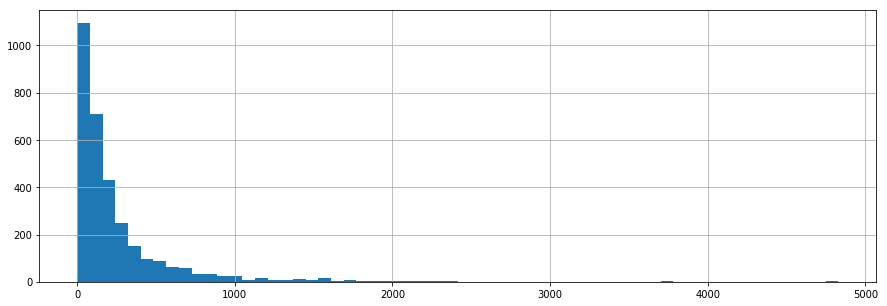

In [9]:
numOfViewsPerProd.hist(bins=60)

In [10]:
numOfViewsPerProdSorted.describe()

count    3181.000000
mean      260.152468
std       403.532928
min         1.000000
25%        57.000000
50%       132.000000
75%       289.000000
max      4828.000000
Name: customer_id, dtype: float64

In [11]:
numOfViewsPerProdSorted.median()

132.0

In [12]:
numOfViewsPerProd[numOfViewsPerProd<20].count()

320

In [13]:
numOfPurchasesPerProdSorted.describe()

count    1910.000000
mean        5.060733
std        11.945023
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       165.000000
Name: customer_id, dtype: float64

In [18]:
numOfPurchasesPerProdSorted.median()

2.0

In [14]:
#-----------Specify the products that have had fewer than 20 views over the whole period
indRemove = numOfViewsPerProd[numOfViewsPerProd<10].index
indRemove

Int64Index([  36,   70,   80,  231,  283,  286,  323,  346,  397,  461,
            ...
            3843, 3844, 3845, 3848, 3851, 3852, 3854, 3855, 3856, 3857],
           dtype='int64', name='product_id', length=158)

In [15]:
numOfPurchasesPerProdSorted[~numOfPurchasesPerProdSorted.index.isin(indRemove)].count()

1883

In [16]:
normalizedViews = numOfViewsPerProdSorted[-(numOfViewsPerProdSorted<20)]
normalizedPurchases = numOfPurchasesPerProdSorted[~numOfPurchasesPerProdSorted.index.isin(indRemove)]

In [18]:
df = pd.DataFrame({'view': normalizedViews, 'purchase': normalizedPurchases})

In [19]:
df.head()

,view,purchase
2,3762.0,126.0
3,3960.0,6.0
14,1164.0,11.0
15,156.0,2.0
17,100.0,NaN


In [20]:
purchasePerView = (df['purchase'] / df['view']).sort_values(ascending=False)
viewPerPurchase = (df['view'] / df['purchase']).sort_values(ascending=False)
purchasePerView.head()

2469    0.500000
1364    0.230769
2359    0.208333
1425    0.181818
825     0.179348
dtype: float64

In [21]:
print("Best Seller Ratio: {}".format(purchasePerView.max()))
print("Least Seller Ratio: {}".format(viewPerPurchase.max()))

Best Seller Ratio: 0.5
Least Seller Ratio: 3571.0


In [22]:
purchasePerView.dropna(inplace=True)

<BarContainer object of 1847 artists>

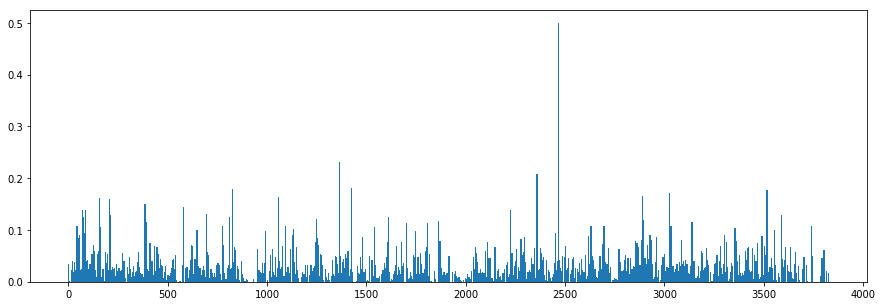

In [23]:
plt.bar(purchasePerView.index, purchasePerView, width = 6)
# purchasePerView.plot.bar(width=5)
# ax1 = plt.gca()
# ax1.axes.get_xaxis().set_visible(False)
# plt.show()
# plt.close()

<BarContainer object of 2897 artists>

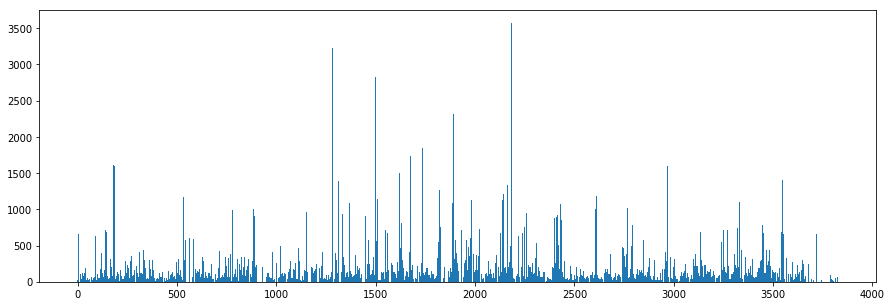

In [24]:
plt.bar(viewPerPurchase.index, viewPerPurchase, width=5)

In [25]:
viewPerPurchase.nlargest(5)

2184    3571.0
1282    3225.0
1501    2820.0
1893    2313.0
1738    1849.0
dtype: float64

In [26]:
purchasePerView.nlargest(5)

2469    0.500000
1364    0.230769
2359    0.208333
1425    0.181818
825     0.179348
dtype: float64

In [27]:
cart_flatten[cart_flatten['product_ids'] == 2469]

,customer_id,product_ids,cart_price
2018-01-31 15:48:26.388,6e7792695c700721,2469,42.88
2018-01-31 15:51:41.150,6e7792695c700721,2469,42.88
2018-01-31 15:51:43.618,6e7792695c700721,2469,42.88
2018-01-31 15:53:06.415,6e7792695c700721,2469,42.88
2018-01-31 15:53:31.383,6e7792695c700721,2469,42.88
2018-01-31 15:53:33.415,6e7792695c700721,2469,42.88
2018-01-31 15:54:00.051,6e7792695c700721,2469,42.88
2018-01-31 15:54:40.887,6e7792695c700721,2469,42.88
2018-01-31 15:54:43.218,6e7792695c700721,2469,42.88
2018-01-31 15:55:56.298,6e7792695c700721,2469,42.88


In [34]:
noSell = views[views['product_id'] == 2184]['Jan 2018':'Sep 2018']
noSell.head()

,customer_id,product_id,full_price,actual_price
timestamp,,,,
2018-01-01 00:23:49.626,a02b997bf5257800,2184,321.487603,321.487603
2018-01-01 00:37:32.533,a02b997bf5257800,2184,321.487603,321.487603
2018-01-01 13:10:54.466,bc5ba20b1f3183f1,2184,321.487603,321.487603
2018-01-01 13:11:38.016,bc5ba20b1f3183f1,2184,321.487603,321.487603
2018-01-01 15:07:16.085,081c3a51286a088a,2184,321.487603,321.487603


In [35]:
noSellByMonth = noSell.resample('M').count()['customer_id']

In [36]:
noSellByMonth

timestamp
2018-01-31    250
2018-02-28    224
2018-03-31    301
2018-04-30    299
2018-05-31    312
2018-06-30    358
2018-07-31    510
2018-08-31    642
2018-09-30    629
Freq: M, Name: customer_id, dtype: int64

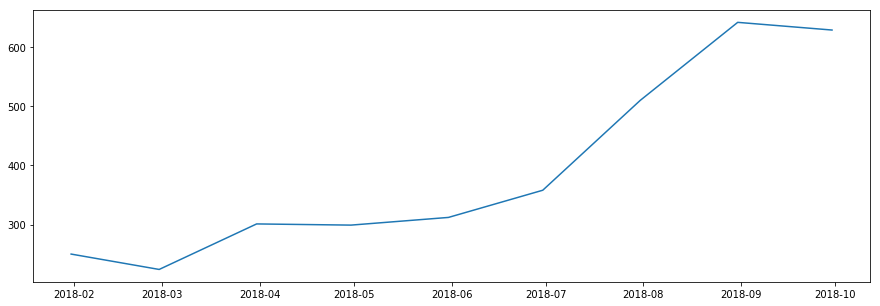

In [37]:
plt.plot(noSellByMonth.index, noSellByMonth)

In [38]:
# product id 825 with purchase ration: 0.179348

bestSellerCart = cart_flatten[cart_flatten['product_ids'] == 825]
bestSellerCart = bestSellerCart['Jan 2018' : 'Sep 2018']
bestSellerCart.head()

,customer_id,product_ids,cart_price
2018-01-04 16:50:39.608,80df2f97917306bb,825,42.00
2018-01-19 17:27:35.528,ff56e18147723fa4,825,879.84
2018-02-05 22:20:38.771,0030800434897a86,825,30.90
2018-02-23 17:19:49.206,548d7b3e16143c18,825,1391.92
2018-03-20 15:28:46.281,4cc26592cce2de11,825,38.20


In [39]:
bestSellerView = views[views['product_id'] == 825]
bestSellerView = bestSellerView['Jan 2018' : 'Sep 2018']
bestSellerView.head()

,customer_id,product_id,full_price,actual_price
timestamp,,,,
2018-01-02 22:34:16.429,47350a2ef01a48cf,825,1.652893,1.652893
2018-01-04 12:06:05.701,1024d82c0cd28c4e,825,1.652893,1.652893
2018-01-04 16:45:52.040,80df2f97917306bb,825,1.652893,1.652893
2018-01-06 01:49:42.030,b10758cb254bc4a1,825,1.652893,1.652893
2018-01-10 01:33:00.186,b10c18fb4fcb6570,825,1.652893,1.652893


In [40]:
bestSellerCartByWeek = bestSellerCart.resample('M').count()['customer_id']
bestSellerViewByWeek = bestSellerView.resample('M').count()['customer_id']

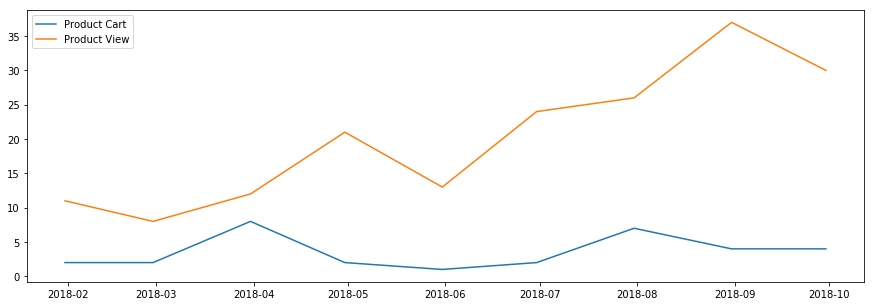

In [41]:
plt.plot(bestSellerCartByWeek.index, bestSellerCartByWeek, label='Product Cart')
plt.plot(bestSellerViewByWeek.index, bestSellerViewByWeek, label='Product View')
plt.legend(loc='upper left')

In [42]:
df['purchase'].nlargest()

44      165.0
47      154.0
1129    154.0
46      153.0
53      145.0
Name: purchase, dtype: float64

In [43]:
cartID44 = cart_flatten[cart_flatten['product_ids'] == 44]['Jan 2018' : 'Sep 2018']
viewID44 = views[views['product_id'] == 44]['Jan 2018' : 'Sep 2018']

In [44]:
cartID44ByDay = cartID44.resample('M').count()['customer_id']
viewID44ByDay = viewID44.resample('M').count()['customer_id']

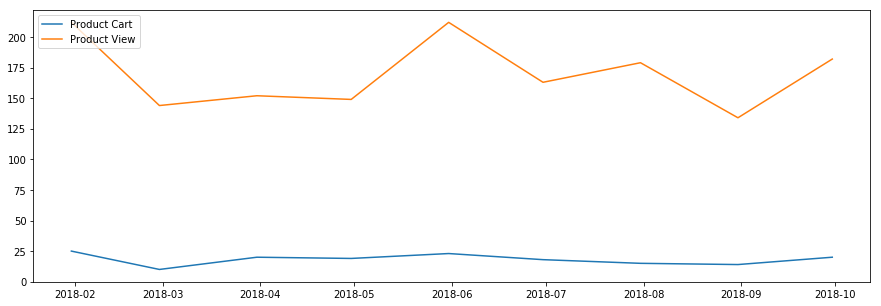

In [45]:
plt.plot(cartID44ByDay.index, cartID44ByDay, label='Product Cart')
plt.plot(viewID44ByDay.index, viewID44ByDay, label='Product View')
plt.legend(loc='upper left')

In [46]:
cartID_1129 = cart_flatten[cart_flatten['product_ids'] == 1129]['Jan 2018' : 'Sep 2018']
viewID_1129 = views[views['product_id'] == 1129]['Jan 2018' : 'Sep 2018']

In [47]:
cartID_1129_ByDay = cartID_1129.resample('M').count()['customer_id']
viewID_1129_ByDay = viewID_1129.resample('M').count()['customer_id']

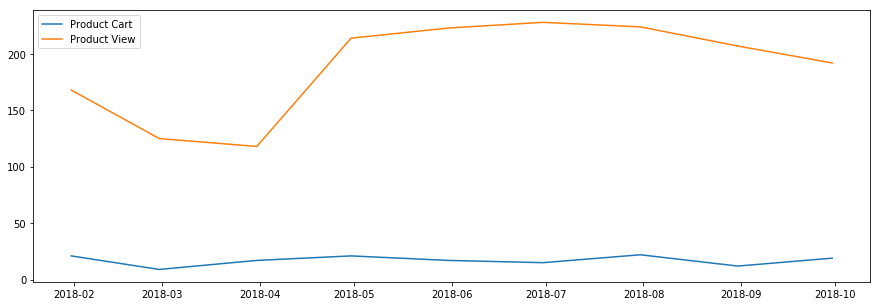

In [48]:
plt.plot(cartID_1129_ByDay.index, cartID_1129_ByDay, label='Product Cart')
plt.plot(viewID_1129_ByDay.index, viewID_1129_ByDay, label='Product View')
plt.legend(loc='upper left')

In [49]:
a = views['jan 2018':'sep 2018']

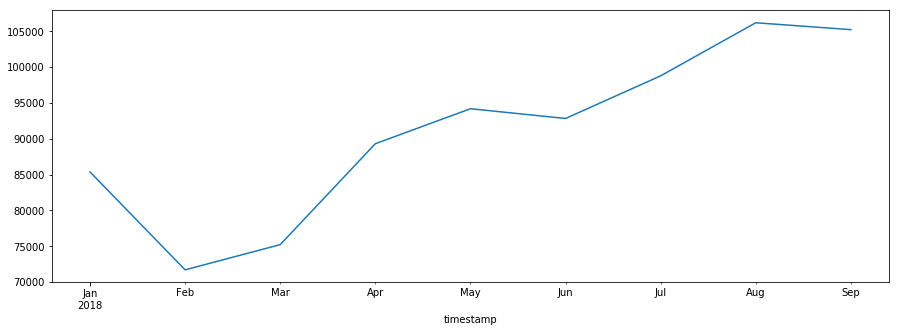

In [50]:
a.resample('M').count()['customer_id'].plot()

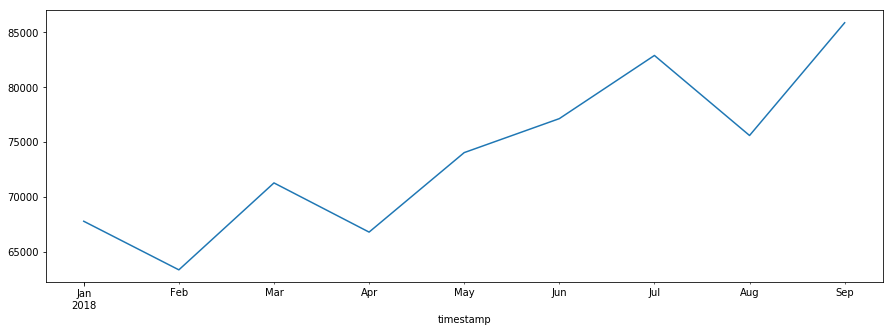

In [51]:
carts['Jan 2018' : 'Sep 2018'].resample('M').sum()['cart_price'].plot()

In [52]:
viewCounts = (views[~views['product_id'].isin(indRemove)]['Jan 2018':'Sep 2018']
              .groupby('product_id')
              .resample('M')
              .count()['customer_id'])

In [62]:
viewCounts.head(15)

product_id  timestamp 
2           2018-01-31    463
            2018-02-28    438
            2018-03-31    320
            2018-04-30    381
            2018-05-31    328
            2018-06-30    464
            2018-07-31    528
            2018-08-31    454
            2018-09-30    362
3           2018-01-31    346
            2018-02-28    343
            2018-03-31    324
            2018-04-30    416
            2018-05-31    395
            2018-06-30    447
Name: customer_id, dtype: int64

In [74]:
purchaseCount = (cart_flatten[~cart_flatten['product_ids'].isin(indRemove)]['Jan 2018':'Sep 2018']
                 .groupby('product_ids')
                 .resample('M')
                 .count()['customer_id'])

In [75]:
purchaseCount.head()

product_ids            
2            2018-01-31    16
             2018-02-28    13
             2018-03-31    15
             2018-04-30    12
             2018-05-31     9
Name: customer_id, dtype: int64

In [97]:
monthlyStat = pd.concat([purchaseCount, viewCounts], axis=1, join='inner', keys=['purchase', 'view'])
monthlyStat.head()

purchase  view
2 2018-01-31        16   463
  2018-02-28        13   438
  2018-03-31        15   320
  2018-04-30        12   381
  2018-05-31         9   328

In [98]:
monthlyStat.loc[15]

,purchase,view
2018-05-31,1,15
2018-06-30,1,19


In [99]:
monthlyStat.reset_index(level=1,drop=True, inplace=True)

In [100]:
monthlyStat.groupby(monthlyStat.index).corr()

purchase      view
2    purchase  1.000000 -0.110291
     view     -0.110291  1.000000
3    purchase  1.000000  0.196388
     view      0.196388  1.000000
14   purchase  1.000000  0.053417
     view      0.053417  1.000000
15   purchase       NaN       NaN
     view           NaN  1.000000
18   purchase       NaN       NaN
     view           NaN  1.000000
23   purchase  1.000000 -0.212022
     view     -0.212022  1.000000
24   purchase       NaN       NaN
     view           NaN       NaN
25   purchase       NaN       NaN
     view           NaN       NaN
27   purchase       NaN       NaN
     view           NaN       NaN
28   purchase       NaN       NaN
     view           NaN       NaN
32   purchase       NaN       NaN
     view           NaN       NaN
33   purchase       NaN       NaN
     view           NaN       NaN
34   purchase       NaN       NaN
     view           NaN       NaN
35   purchase       NaN       NaN
     view           NaN       NaN
37   purchase  1.000000 -0.516722
     view     -0.516722  1.000000
...                 ...       ...
3701 purchase       NaN       NaN
     view           NaN       NaN
3703 purchase       NaN       NaN
     view           NaN       NaN
3717 purchase       NaN       NaN
     view           NaN       NaN
3720 purchase       NaN       NaN
     view           NaN       NaN
3722 purchase       NaN       NaN
     view           NaN       NaN
3742 purchase  1.000000 -1.000000
     view     -1.000000  1.000000
3743 purchase       NaN       NaN
     view           NaN       NaN
3771 purchase       NaN       NaN
     view           NaN       NaN
3789 purchase       NaN       NaN
     view           NaN       NaN
3793 purchase       NaN       NaN
     view           NaN       NaN
3794 purchase       NaN       NaN
     view           NaN       NaN
3801 purchase       NaN       NaN
     view           NaN       NaN
3804 purchase       NaN       NaN
     view           NaN       NaN
3815 purchase       NaN       NaN
     view           NaN       NaN
3849 purchase       NaN       NaN
     view           NaN       NaN

[3754 rows x 2 columns]

In [82]:
a.corr()

customer_id  customer_id
(2, 2018-01-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-02-28 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-03-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-04-30 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-05-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-06-30 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-07-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-08-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(2, 2018-09-30 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3, 2018-02-28 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3, 2018-03-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3, 2018-04-30 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3, 2018-05-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3, 2018-06-30 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3, 2018-07-31 00:00:00)    customer_id          NaN          NaN
                            customer_id          NaN          NaN
...                                              ...          ...
(3703, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3717, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3720, 2018-07-31 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3722, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3742, 2018-08-31 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3742, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3743, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3771, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3789, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3793, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3794, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3801, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3804, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3815, 2018-09-30 00:00:00) customer_id          NaN          NaN
                            customer_id          NaN          NaN
(3849, 2018-09-30 00:00:00) customer_id          NaN          NaN
               

In [130]:
views[views['product_id'] == 3742].index[lastEntry]

Timestamp('2018-10-02 19:17:09.567000')

In [123]:
views[views['product_id'] == 3742].tail()

,customer_id,product_id,full_price,actual_price
timestamp,,,,
2018-10-02 11:55:15.994,fdf7cc89ddbc5295,3742,10.743802,10.743802
2018-10-02 12:08:40.489,fdf7cc89ddbc5295,3742,10.743802,10.743802
2018-10-02 13:25:12.825,c8ecfa75063e9051,3742,10.743802,10.743802
2018-10-02 19:16:10.209,ee6b6897ab6059f5,3742,10.743802,10.743802
2018-10-02 19:17:09.567,ee6b6897ab6059f5,3742,10.743802,10.743802


In [135]:
lastEntry = len(views[views['product_id'] == 2]) - 1

In [141]:
(views[views['product_id'] == 2].index[lastEntry] - views[views['product_id'] == 2].index[0]) > pd.Timedelta(days=300)

False

In [17]:
def timeDelta(pid):
    lastEntry = len(views[views['product_id'] == pid]) - 1
    res = ((views[views['product_id'] == pid].index[lastEntry] - views[views['product_id'] == pid].index[0]) 
           >
           pd.Timedelta(days=150))
    return res

In [10]:
timeDelta(1962)

False

In [13]:
views.head()

,customer_id,product_id,full_price,actual_price
timestamp,,,,
2017-12-31 23:00:21.389,a1768f6141ba9932,1962,238.842975,167.190083
2017-12-31 23:02:09.316,9afedb29c50f8ab9,804,57.024793,57.024793
2017-12-31 23:02:43.368,f5d79ddd326abb30,1681,57.851240,57.851240
2017-12-31 23:03:10.137,64937cc7dc6d57dd,2005,164.462810,115.123967
2017-12-31 23:03:17.932,9c4edff0e7e785e7,2546,681.820579,681.820579


In [19]:
ind = []
for row in views['product_id'].unique():
    if timeDelta(row):
        ind.append(row)

In [21]:
viewCounts = (views[views['product_id'].isin(ind)]['Jan 2018':'Sep 2018']
              .groupby('product_id')
              .resample('M')
              .count()['customer_id'])

In [23]:
viewCounts.head()

product_id  timestamp 
2           2018-01-31    463
            2018-02-28    438
            2018-03-31    320
            2018-04-30    381
            2018-05-31    328
Name: customer_id, dtype: int64

In [27]:
purchaseCount = (cart_flatten[cart_flatten['product_ids'].isin(ind)]['Jan 2018':'Sep 2018']
                 .groupby('product_ids')
                 .resample('M')
                 .count()['customer_id'])